# **Q-Learning with FrozenLake-v1 ⛄ and Taxi-v3 🚕**


## **Install dependencies and create a virtual display 🔽**

In the notebook, we'll need to generate a replay video. To do so, with Colab, **we need to have a virtual screen to render the environment** (and thus record the frames).

Hence the following cell will install the libraries and create and run a virtual screen 🖥

We’ll install multiple ones:

- `gymnasium`: Contains the FrozenLake-v1 ⛄ and Taxi-v3 🚕 environments.
- `pygame`: Used for the FrozenLake-v1 and Taxi-v3 UI.
- `numpy`: Used for handling our Q-table.

In [ ]:
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit2/requirements-unit2.txt

In [ ]:
%%capture
!sudo apt-get update
!apt install python-opengl ffmpeg xvfb
!pip3 install pyvirtualdisplay

In [ ]:
# Virtual display
# libraries for display whole of episode as a video:
import pyvirtualdisplay
from IPython import display
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
from matplotlib import animation

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

## **Import the packages 📦**

In addition to the installed libraries, we also use:

- `random`: To generate random numbers (that will be useful for epsilon-greedy policy).
- `imageio`: To generate a replay video.

In [ ]:
import numpy as np
import gymnasium as gym
import random
import imageio
import os
import tqdm

import pickle5 as pickle
from tqdm.notebook import tqdm

## **Part 1: Frozen Lake ⛄ (non slippery version)**

**Create and understand [FrozenLake environment ⛄]((https://gymnasium.farama.org/environments/toy_text/frozen_lake/)**


We're going to train our Q-Learning agent **to navigate from the starting state (S) to the goal state (G) by walking only on frozen tiles (F) and avoid holes (H)**.

We can have two sizes of environment:

- `map_name="4x4"`: a 4x4 grid version
- `map_name="8x8"`: a 8x8 grid version


The environment has two modes:

- `is_slippery=False`: The agent always moves **in the intended direction** due to the non-slippery nature of the frozen lake (deterministic).
- `is_slippery=True`: The agent **may not always move in the intended direction** due to the slippery nature of the frozen lake (stochastic).

For now let's keep it simple with the 4x4 map and non-slippery.
We add a parameter called `render_mode` that specifies how the environment should be visualised. In our case because we **want to record a video of the environment at the end, we need to set render_mode to rgb_array**.

As [explained in the documentation](https://gymnasium.farama.org/api/env/#gymnasium.Env.render) “rgb_array”: Return a single frame representing the current state of the environment. A frame is a np.ndarray with shape (x, y, 3) representing RGB values for an x-by-y pixel image.

In [ ]:
# Create the FrozenLake-v1 environment using 4x4 map and non-slippery version and render_mode="rgb_array"
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")

**Let's see what the Environment looks like:**


In [ ]:
# We create our environment with gym.make("<name_of_the_environment>")- `is_slippery=False`: The agent always moves in the intended direction due to the non-slippery nature of the frozen lake (deterministic).
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Discrete(16)
Sample observation 5


We see with `Observation Space Shape Discrete(16)` that the observation is an integer representing the **agent’s current position as current_row * nrows + current_col (where both the row and col start at 0)**.

For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map. **For example, the 4x4 map has 16 possible observations.**


For instance, this is what state = 0 looks like:

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit2/frozenlake.png" alt="FrozenLake">

In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 0


The action space (the set of possible actions the agent can take) is discrete with 4 actions available 🎮:
- 0: GO LEFT
- 1: GO DOWN
- 2: GO RIGHT
- 3: GO UP

Reward function 💰:
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

We're now ready to code our Q-Learning algorithm 🔥

### Step-1: Creating Q-Table

It's time to initialize our Q-table! To know how many rows (states) and columns (actions) to use, we need to know the action and observation space. We already know their values from before, but we'll want to obtain them programmatically so that our algorithm generalizes for different environments. Gym provides us a way to do that: `env.action_space.n` and `env.observation_space.n`

In [ ]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  16  possible states
There are  4  possible actions


In [ ]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

In [ ]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)

Our Q-Table:

In [ ]:
Qtable_frozenlake

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

### Step-2: Define epsilon-greedy-policy and greedy policy

Remember we have two policies since Q-Learning is an **off-policy** algorithm. This means we're using a **different policy for acting and updating the value function**.

- Epsilon-greedy policy (acting policy)
- Greedy-policy (updating policy)

The greedy policy will also be the final policy we'll have when the Q-learning agent completes training. The greedy policy is used to select an action using the Q-table.

In [ ]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state][:])

  return action

Epsilon-greedy is the training policy that handles the exploration/exploitation trade-off.

The idea with epsilon-greedy:

- With *probability 1 - ɛ* : **we do exploitation** (i.e. our agent selects the action with the highest state-action pair value).

- With *probability ɛ*: we do **exploration** (trying a random action).

As the training continues, we progressively **reduce the epsilon value since we will need less and less exploration and more exploitation.**

In [ ]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_int = random.uniform(0,1)
  # if random_int > greater than epsilon --> exploitation
  if random_int > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action = greedy_policy(Qtable, state)
  # else --> exploration
  else:
    action = env.action_space.sample()

  return action

### Step-3: Define the hyperparameters ⚙️

The exploration related hyperparamters are some of the most important ones.

- We need to make sure that our agent **explores enough of the state space** to learn a good value approximation. To do that, we need to have progressive decay of the epsilon.
- If you decrease epsilon too fast (too high decay_rate), **you take the risk that your agent will be stuck**, since your agent didn't explore enough of the state space and hence can't solve the problem.

In [ ]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"     # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob

### Step-4: Create the training loop method

The training loop goes like this:

```
For episode in the total of training episodes:

Reduce epsilon (since we need less and less exploration)
Reset the environment

  For step in max timesteps:    
    Choose the action At using epsilon greedy policy
    Take the action (a) and observe the outcome state(s') and reward (r)
    Update the Q-value Q(s,a) using Bellman equation Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
    If done, finish the episode
    Our next state is the new state
```

In [ ]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in tqdm(range(n_training_episodes)):
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state = env.reset()
    # for append all frames of taking action to show as a gif later
    img = []
    # append first frame
    ###img.append(env.render('rgb_array'))
    step = 0
    terminated = False
    truncated = False

    # repeat
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action = epsilon_greedy_policy(Qtable, state, epsilon)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, terminated, info = env.step(action)

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

      # append frames
      ###img.append(env.render('rgb_array'))

      # If terminated or truncated finish the episode
      if terminated:
        break

      # Our next state is the new state
      state = new_state
  return Qtable,img

### Step-5: Train the Q-Learning agent 🏃

In [ ]:
import gym
env = gym.make('FrozenLake-v1')
Qtable_frozenlake,img = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  0%|          | 0/25000 [00:00<?, ?it/s]

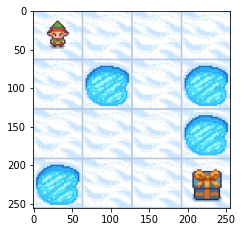

In [ ]:
dpi = 72
interval = 200 # ms

plt.figure(figsize=(img[0].shape[1]/dpi,img[0].shape[0]/dpi),dpi=dpi)
patch = plt.imshow(img[0])
plt.axis=('off')
animate = lambda i: patch.set_data(img[i])
ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img),interval=interval)
display.display(display.HTML(ani.to_jshtml()))

Let's see what our Q-Learning table looks like now 👀



In [ ]:
Qtable_frozenlake

array([[8.21116838e-02, 8.27845943e-02, 7.85508835e-02, 6.84679045e-02],
       [1.94446228e-02, 1.86072147e-02, 1.41351282e-02, 6.33088244e-02],
       [2.92803158e-02, 2.57660843e-02, 1.26729484e-02, 3.35736481e-02],
       [2.80824156e-03, 1.49638200e-02, 2.14227516e-02, 3.43726450e-02],
       [8.22688331e-02, 7.64858287e-02, 5.56242498e-02, 1.54858977e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.18462592e-02, 5.01045226e-04, 8.01516469e-04, 1.00002700e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.09699567e-03, 3.56905377e-02, 3.65175579e-02, 8.24048643e-02],
       [2.74161780e-02, 1.38467642e-01, 4.30006764e-02, 3.70752074e-02],
       [7.25734062e-03, 4.65147990e-03, 4.93560822e-03, 5.70621541e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.23843334e-01, 1.71661756e-01, 7.80709923e

### Step-6: Evalate our Q-Learning agent 📝

- We defined the evaluation method that we're going to use to test our Q-Learning agent.

In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  :param seed: The evaluation seed array (for taxi-v3)
  """
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):
    if seed:
      state = env.reset(seed=seed[episode])
    else:
      state = env.reset()
    step = 0
    terminated = False
    total_rewards_ep = 0

    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      action = greedy_policy(Q, state)
      new_state, reward, terminated, info = env.step(action)
      total_rewards_ep += reward

      if terminated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

**Evaluate our Q-Learning agent 📈**

- Usually, you should have a mean reward of 1.0
- The **environment is relatively easy** since the state space is really small (16). What you can try to do is [to replace it with the slippery version](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/), which introduces stochasticity, making the environment more complex.

In [ ]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean_reward=0.53 +/- 0.50


## **Part 2: Taxi-v3 🚖**

Create and understand [Taxi-v3 🚕](https://gymnasium.farama.org/environments/toy_text/taxi/)


In `Taxi-v3` 🚕, there are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue).

When the episode starts, **the taxi starts off at a random square** and the passenger is at a random location. The taxi drives to the passenger’s location, **picks up the passenger**, drives to the passenger’s destination (another one of the four specified locations), and then **drops off the passenger**. Once the passenger is dropped off, the episode ends.


<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit2/taxi.png" alt="Taxi">


In [ ]:
env = gym.make("Taxi-v3")

There are **500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger** (including the case when the passenger is in the taxi), and **4 destination locations.**


In [ ]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

There are  500  possible states


In [ ]:
action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  6  possible actions


The action space (the set of possible actions the agent can take) is discrete with **6 actions available 🎮**:

- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger

Reward function 💰:

- -1 per step unless other reward is triggered.
- +20 delivering passenger.
- -10 executing “pickup” and “drop-off” actions illegally.

### Step-1: Creating Q-Table

In [ ]:
# Create our Q table with state_size rows and action_size columns (500x6)
Qtable_taxi = initialize_q_table(state_space, action_space)
print(Qtable_taxi)
print("Q-table shape: ", Qtable_taxi .shape)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Q-table shape:  (500, 6)


### Step-3: Define the hyperparameters ⚙️

The exploration related hyperparamters are some of the most important ones.

- We need to make sure that our agent **explores enough of the state space** to learn a good value approximation. To do that, we need to have progressive decay of the epsilon.
- If you decrease epsilon too fast (too high decay_rate), **you take the risk that your agent will be stuck**, since your agent didn't explore enough of the state space and hence can't solve the problem.

⚠ DO NOT MODIFY EVAL_SEED: the eval_seed array **allows us to evaluate your agent with the same taxi starting positions for every classmate**

In [ ]:
# Training parameters
n_training_episodes = 25000   # Total training episodes
learning_rate = 0.7           # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# DO NOT MODIFY EVAL_SEED
eval_seed = [16,54,165,177,191,191,120,80,149,178,48,38,6,125,174,73,50,172,100,148,146,6,25,40,68,148,49,167,9,97,164,176,61,7,54,55,
 161,131,184,51,170,12,120,113,95,126,51,98,36,135,54,82,45,95,89,59,95,124,9,113,58,85,51,134,121,169,105,21,30,11,50,65,12,43,82,145,152,97,106,55,31,85,38,
 112,102,168,123,97,21,83,158,26,80,63,5,81,32,11,28,148] # Evaluation seed, this ensures that all classmates agents are trained on the same taxi starting position
                                                          # Each seed has a specific starting state

# Environment parameters
env_id = "Taxi-v3"           # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05           # Minimum exploration probability
decay_rate = 0.005            # Exponential decay rate for exploration prob


### Step-5: Train our Q-Learning agent 🏃

In [ ]:
import gym
env = gym.make("Taxi-v3")
Qtable_taxi = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_taxi)
Qtable_taxi

  0%|          | 0/25000 [00:00<?, ?it/s]

(array([[  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  2.75200369,   3.94947742,   2.75200369,   3.94947757,
           5.20997639,  -5.05052244],
        [  7.93349184,   9.40367562,   7.93349184,   9.40367562,
          10.9512375 ,   0.40367562],
        ...,
        [  4.21744281,  12.58025   ,  -2.94215523,  -3.30647191,
         -11.98951843, -10.14096134],
        [ -3.32800871,  -3.57151808,  -4.35998196,   6.53681724,
          -6.54291206,  -7.83334075],
        [ 16.1       ,  14.295     ,  16.1       ,  18.        ,
           7.1       ,   7.1       ]]),
 [])